# Project 3

# Introduction

When we are in every shopping, our credit card will face a threat of attack. No matter when you pay any bill, you may face the threat of attack. However, how should you face it? How do you know if you're vulnerable? All this needs to be solved through this experiment. 

# Abstrct

In this experiment, we answered a question posed by IEEE and VESTA. Through the test data, we established two models, KNN model and random forest model, to simulate the attack of users. At the same time, we tested these two models and finally obtained the possibility of the final user being attacked. Through this experiment, we will learn the role of the classification model and how to use the method.

For this experiment, the first is to carry out this part of EDA, first began to process data, will be a clean data output, and visual processing, draw the image.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import re
import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Competition Objective is to detect fraud in transactions

## Load data

In [4]:
df_tran = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv", engine='c')
df_id = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv", engine='c')

In [5]:
print(df_tran.shape, df_id.shape)

(590540, 394) (144233, 41)


In [6]:
train_full = pd.merge(df_id, df_tran, on = 'TransactionID')

In [7]:
df_tran.sample(frac=0.8).reset_index(drop=True)
print(df_tran['isFraud'].value_counts())
print("------------------------------")
print(df_tran.columns)

0    569877
1     20663
Name: isFraud, dtype: int64
------------------------------
Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)


We can see the number of positive and negative samples before processing and Data column before processing

In [8]:
train_full.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 0 to 144232
Data columns (total 434 columns):
TransactionID     144233 non-null int64
id_01             144233 non-null float64
id_02             140872 non-null float64
id_03             66324 non-null float64
id_04             66324 non-null float64
id_05             136865 non-null float64
id_06             136865 non-null float64
id_07             5155 non-null float64
id_08             5155 non-null float64
id_09             74926 non-null float64
id_10             74926 non-null float64
id_11             140978 non-null float64
id_12             144233 non-null object
id_13             127320 non-null float64
id_14             80044 non-null float64
id_15             140985 non-null object
id_16             129340 non-null object
id_17             139369 non-null float64
id_18             45113 non-null float64
id_19             139318 non-null float64
id_20             139261 non-null float64
id_21             515

- Enumerable features:
  - ProductCD
  - card4
  - card6
  - P_emaildomain
  - R_emaildomain
  - M1 - M9

- Numeric features:
  - TransactionDT
  - TransactionAmt
  - card1 - card3
  - card5
  - addr1 - addr2
  - dist1 - dist2
  - C1 - C14
  - D1 - D15
  - V1 - V399

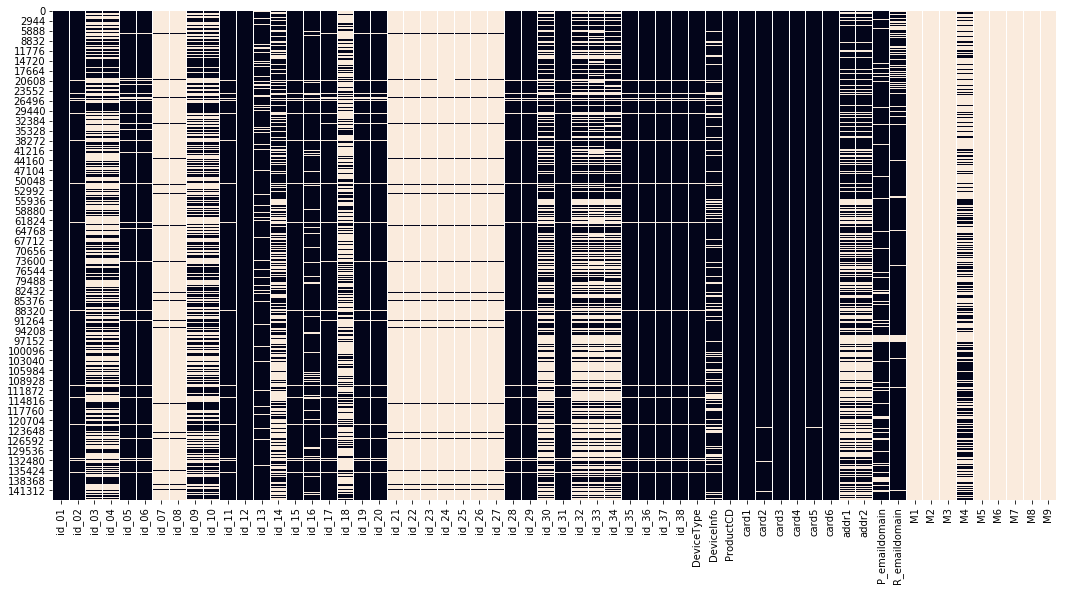

In [9]:
train_full_cat = train_full.filter(regex='id|card|ProductCD|addr|email|M|DeviceType|DeviceInfo')
plt.figure(figsize=(18,9))
sns.heatmap(train_full_cat.isnull(), cbar= False)

* The white color presents missing values. We can see that our data has a lot of missing values.
* Most M columns missing almost if not all data
* Id_07, 08 and id_21-27 missing most data

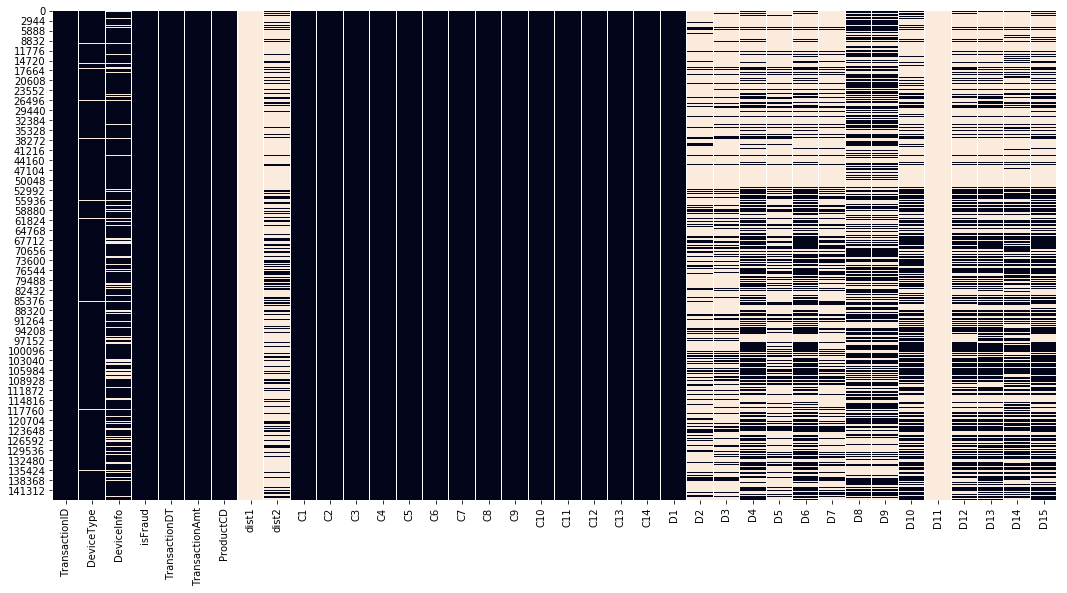

In [10]:
train_full_num = train_full.filter(regex='isFraud|TransactionDT|TransactionAmt|dist|C|D')
plt.figure(figsize=(18,9))
sns.heatmap(train_full_num.isnull(), cbar= False)

* Dist1 and dist2 are very sparse
* Basic information about the transaction, such as ID, DT, product quantity and type have been completed
* Column C is completed
** Most D columns are sparse except D1

## Data analysis

,0,1
isFraud,0.96501,0.03499


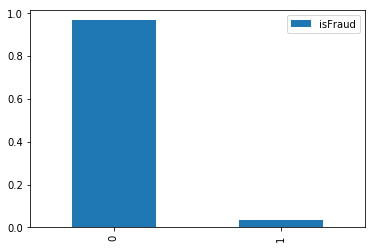

In [11]:
fc = df_tran['isFraud'].value_counts(normalize=True).to_frame()
fc.plot.bar()
fc.T

fraud transaction rate by day, and week

### Examine Product Code

In [12]:
train_full[train_full['isFraud'] == 1]['ProductCD'].value_counts(normalize = True)


C    0.675031
H    0.138805
R    0.125729
S    0.060435
Name: ProductCD, dtype: float64

In [13]:
train_full.groupby('ProductCD')['isFraud'].value_counts(normalize = True)

ProductCD  isFraud
C          0          0.877155
           1          0.122845
H          0          0.952261
           1          0.047739
R          0          0.962102
           1          0.037898
S          0          0.940958
           1          0.059042
Name: isFraud, dtype: float64

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<Figure size 864x864 with 0 Axes>

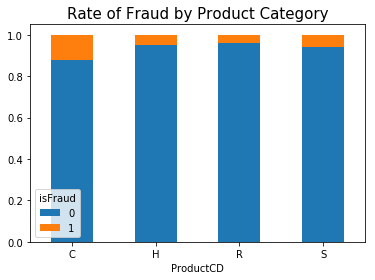

In [14]:
plt.figure(figsize=(12,12))
a = train_full.groupby('ProductCD')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('Rate of Fraud by Product Category', fontsize = 15)
plt.xticks(rotation='horizontal')

Product C accounts for a large portion of fraud cases in transactions with identity. And the fraud rate is the highest, more than twice that of any other category. We have 2 numeric variables that can be compared between product groups:
* TransactionDT: timedelta given the reference date and time
* TransactionAmt: Transaction payment amount in US dollars

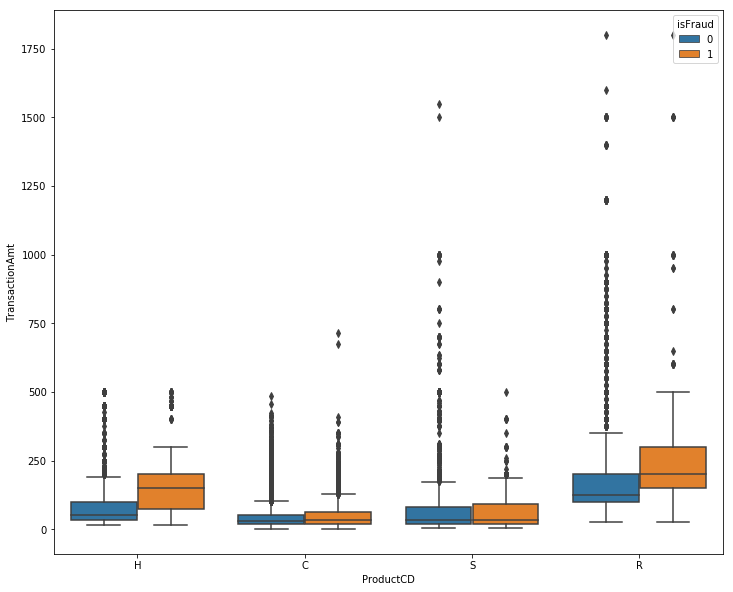

In [15]:
plt.figure(figsize=(12,10))
sns.boxplot(x = 'ProductCD', y = 'TransactionAmt', hue = 'isFraud', data = train_full)

From this figure, it can be seen that the two kinds of data are similar and conform to the data characteristics in the data set.

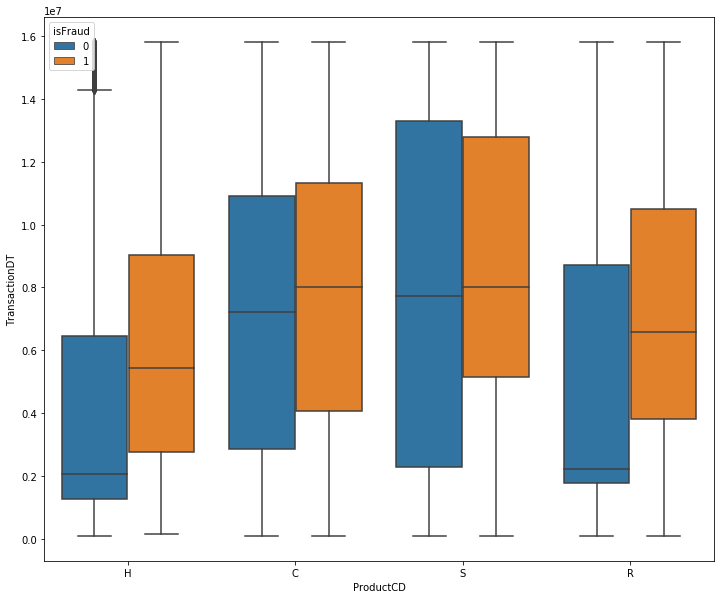

In [16]:
plt.figure(figsize=(12,10))
sns.boxplot(x = 'ProductCD', y = 'TransactionDT', hue = 'isFraud', data = train_full)

All products have same min and max timedelta range.

### Examine Transaction Amount

In [17]:
def visualize_num_variable(variable, df=train_full):
    plt.figure(figsize=(12,18))
    plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)

    plt.subplot(321)
    sns.distplot(df[variable], kde= False)
    plt.title('{} Distribution'.format(variable), fontsize = 15)
#Log-transformed Distribution
    plt.subplot(322)
    sns.distplot(np.log10(df[variable]), kde= False)
    plt.title('Log-transformed Distribution', fontsize = 15)

#Fraud vs Non-Fraud Distribution
    plt.subplot(323)
    sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
    sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
    plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
    plt.legend()
#Log-transformed Distribution
    plt.subplot(324)
    sns.distplot(np.log10(df[df['isFraud'] == 0][variable]), color = 'skyblue', kde= False, label = 'Not Fraud')
    sns.distplot(np.log10(df[df['isFraud'] == 1][variable]), color = 'red', kde= False , label = 'Fraud')
    plt.title('Log-transformed Distribution', fontsize = 15)
    plt.legend()
    
#Transaction Amount by Fraud
    plt.subplot(313)
    sns.boxplot(x = 'isFraud', y = variable, data = df)
    plt.title('Transaction Amount by Fraud', fontsize = 15,  weight='bold')

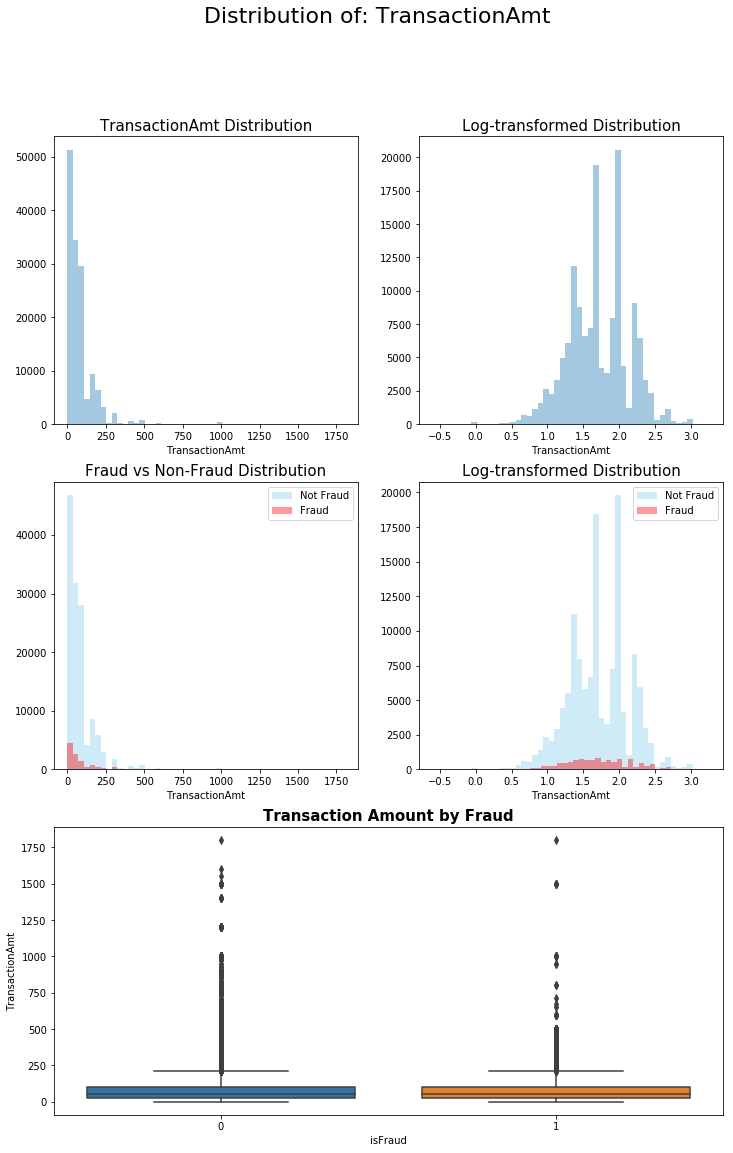

In [18]:
visualize_num_variable('TransactionAmt')

* TransactionAmt has a right-biased distribution: most transactions are small (less than $200)
* TransactionAmt is dynamically distributed
* There is almost no difference between the distribution of fraud and non-fraud and the average amount

### Examine DeviceInfo

In [19]:
train_full['DeviceInfo'].value_counts()

Windows                  47722
iOS Device               19782
MacOS                    12573
Trident/7.0               7440
rv:11.0                   1901
                         ...  
LG-D320                      1
SM-G900V Build/LRX21T        1
SM-G730V                     1
LGMS323                      1
6055B                        1
Name: DeviceInfo, Length: 1786, dtype: int64

We select categories that have more than 500 counts

In [20]:
def visualize_cat_cariable(variable, df=train_full):
    train_full[variable].fillna("NA", inplace=True)
    variable_fraud_rate = df.groupby(variable)['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
    plt.figure(figsize=(12,6))

    g = sns.countplot(x = variable, data = df, order = variable_fraud_rate.index)


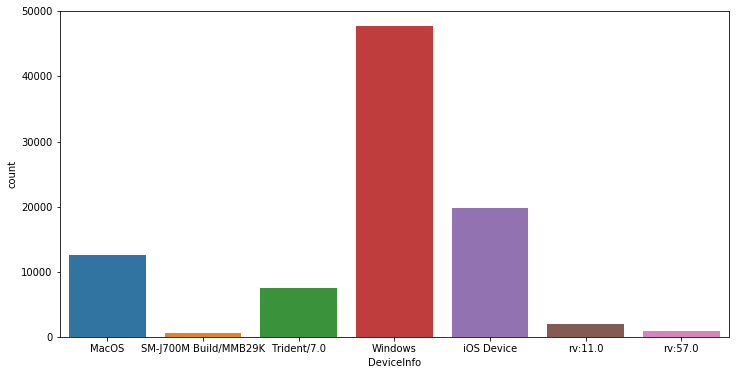

In [21]:
devicelist = train_full.groupby('DeviceInfo').filter(lambda x: len(x) >500)['DeviceInfo'].unique()
visualize_cat_cariable('DeviceInfo', df = train_full[train_full['DeviceInfo'].isin(devicelist)])

We can see the fraud rate is higher for certain devices

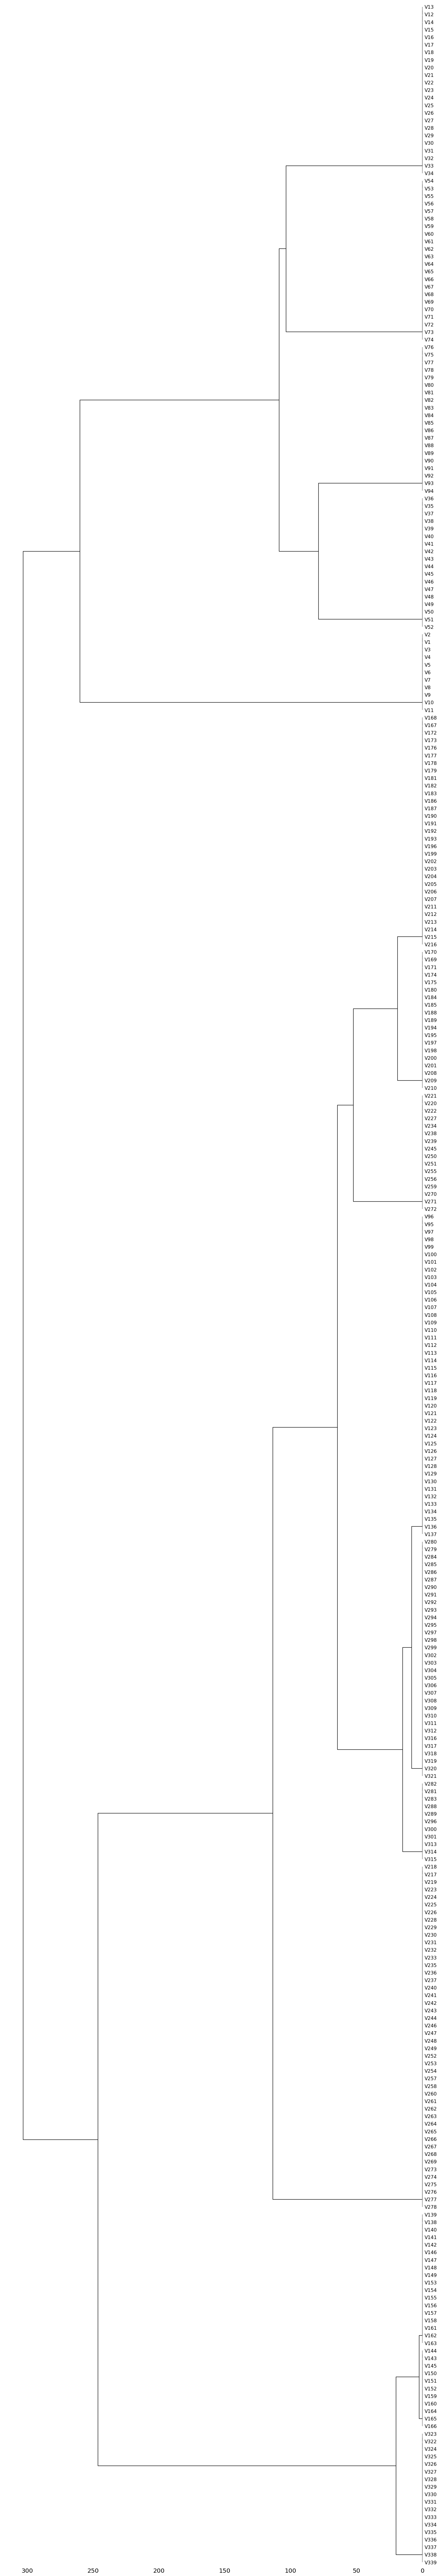

In [22]:
train_full_Vesta = train_full.filter(regex='V')
msno.dendrogram(train_full_Vesta)

Each cluster of leaves shows how a variable is always empty when another variable is empty, or how empty when another variable is filled. The tree diagram indicates that the location of the missing/filled values is relevant. The columns are derived from the same feature or combination of features.

## The modle of Knn

In [23]:
import pandas as pd
def convert_TF(var):
    return float(1.0) if var=='T' else float(0.0)
def convert_Found(var):
    return float(1.0) if var=='Found' else float(0.0)
def convert_ProductCD(var):
    if var=='C': value=float(1.0)
    if var=='H': value=float(2.0)
    if var=='R': value=float(3.0)
    if var=='S': value=float(4.0)
    return value

In [24]:
train_tran_pre = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv", engine='c',iterator=True,
                                    usecols=['TransactionID','isFraud','TransactionDT','TransactionAmt','ProductCD'])
train_tran=train_tran_pre.get_chunk(500000)
train_tran.sample(frac=0.8).reset_index(drop=True)
print(train_tran['isFraud'].value_counts())
print("------------------------------")
print(train_tran.columns) 

0    482479
1     17521
Name: isFraud, dtype: int64
------------------------------
Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD'],
      dtype='object')


Number of positive and negative samples before processing and rows and columns of data before processing

In [25]:
train_tran_positive=train_tran[train_tran['isFraud']==1] 
train_tran_negative=train_tran[train_tran['isFraud']==0] 


del train_tran
train_tran_negative=train_tran_negative.sample(n=400000) 
train_tran_modify=train_tran_negative.append(train_tran_positive) 
del(train_tran_negative,train_tran_positive)

In [26]:
for col in train_tran_modify.columns:
    if str(train_tran_modify[col].dtype) == 'object':
        print(col)
print("----------------------------------------")
print(train_tran_modify.isnull().sum())
print("----------------------------------------")
print(train_tran_modify['isFraud'].value_counts())

ProductCD
----------------------------------------
TransactionID     0
isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
dtype: int64
----------------------------------------
0    400000
1     17521
Name: isFraud, dtype: int64


The null value after processing and the number of positive and negative samples after processing are as follows

In [27]:
train_id_pre = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv", engine='c',
                                  usecols=['TransactionID','id_29','id_35','id_36','id_37','id_38'],iterator=True)
train_id=train_id_pre.get_chunk(50000)
train_id.sample(frac=1).reset_index(drop=True)


,TransactionID,id_29,id_35,id_36,id_37,id_38
0,3097742,Found,T,F,T,T
1,3094080,Found,T,F,T,T
2,3080661,Found,T,F,T,F
3,3052587,Found,T,F,T,F
4,3082291,Found,T,F,T,F
...,...,...,...,...,...,...
49995,3007147,NotFound,F,F,T,T
49996,3049038,Found,F,F,T,T
49997,3036205,Found,F,F,T,T
49998,3070361,Found,T,F,T,F


In [28]:
for col in train_id.columns:
    if str(train_id[col].dtype) == 'object':
        print(col)
print("----------------------------------------")
print(train_id.isnull().sum())
print("----------------------------------------")
print(train_id.shape)

id_29
id_35
id_36
id_37
id_38
----------------------------------------
TransactionID       0
id_29            1218
id_35            1218
id_36            1218
id_37            1218
id_38            1218
dtype: int64
----------------------------------------
(50000, 6)


Dataset rows and columns and null values for the first file

In [29]:
df_source=pd.merge(train_id, train_tran_modify, on='TransactionID',how='inner')  # 
del(train_id,train_tran_modify)
print(df_source.shape)
# print(df_train.head(1))
print("------------------------------")

print(df_source['isFraud'].value_counts())

(41865, 10)
------------------------------
0    40366
1     1499
Name: isFraud, dtype: int64


Final dataset rows and columns and the number of final positive and negative samples

In [30]:
print("The final non-numeric type：")
for col in df_source.columns:
    if str(df_source[col].dtype) == 'object':
        print(col)
print(df_source.isnull().sum())
print(df_source.shape)

The final non-numeric type：
id_29
id_35
id_36
id_37
id_38
ProductCD
TransactionID       0
id_29             993
id_35             993
id_36             993
id_37             993
id_38             993
isFraud             0
TransactionDT       0
TransactionAmt      0
ProductCD           0
dtype: int64
(41865, 10)


In [31]:

print(df_source['isFraud'].value_counts())

for col in df_source.columns:
    if str(df_source[col].dtype) == 'object':
        print(col)

0    40366
1     1499
Name: isFraud, dtype: int64
id_29
id_35
id_36
id_37
id_38
ProductCD


The final positive and negative sample number and the final non-numeric type of field

Final data content and null values

In [32]:
df_source=df_source.fillna(axis=0,method='ffill')
print("Processing null content")
print(df_source.isnull().sum())
print(df_source.dtypes)
df_source['isFraud'].astype(float)



df_source['id_35']=df_source['id_35'].apply(convert_TF)
df_source['id_36']=df_source['id_36'].apply(convert_TF)
df_source['id_37']=df_source['id_37'].apply(convert_TF)
df_source['id_38']=df_source['id_38'].apply(convert_TF)
df_source['id_29']=df_source['id_29'].apply(convert_Found)
df_source['ProductCD']=df_source['ProductCD'].apply(convert_ProductCD)



df_source = df_source.drop(['TransactionDT'],axis=1)

df_source = df_source.drop(['TransactionID'],axis=1)

Processing null content
TransactionID     0
id_29             0
id_35             0
id_36             0
id_37             0
id_38             0
isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
dtype: int64
TransactionID       int64
id_29              object
id_35              object
id_36              object
id_37              object
id_38              object
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
dtype: object


In [33]:
print(df_source.head(10))
print(df_source.dtypes)

   id_29  id_35  id_36  id_37  id_38  isFraud  TransactionAmt  ProductCD
0    0.0    1.0    0.0    1.0    1.0        0          50.000        2.0
1    1.0    0.0    0.0    1.0    1.0        0          75.887        1.0
2    0.0    0.0    0.0    1.0    1.0        0          16.495        1.0
3    1.0    1.0    0.0    1.0    1.0        0         100.000        2.0
4    1.0    1.0    0.0    1.0    1.0        0          25.000        4.0
5    1.0    0.0    0.0    1.0    1.0        0          75.887        1.0
6    0.0    0.0    0.0    1.0    1.0        0          42.294        1.0
7    0.0    0.0    0.0    1.0    1.0        0           3.595        1.0
8    1.0    1.0    0.0    1.0    1.0        0         300.000        2.0
9    1.0    1.0    0.0    1.0    1.0        0          20.000        4.0
id_29             float64
id_35             float64
id_36             float64
id_37             float64
id_38             float64
isFraud             int64
TransactionAmt    float64
ProductCD      

In [34]:
# y = df_source['isFraud']
# df_source = df_source.drop(['isFraud'],axis=1)
# y = df_source['isFraud'].values
y = df_source['isFraud']
df_source = df_source.drop(['isFraud'],axis=1)
# x = df_source.values
x = df_source


print('shape of X {}; shape of Y {}'.format(x.shape, y.shape))

x_train , x_test ,y_train , y_test= train_test_split(x, y, random_state = 0)

shape of X (41865, 7); shape of Y (41865,)


In [35]:
print ("x_test shape is :",x_test.shape)
print ("y_test shape is :",y_test.shape)


x_test shape is : (10467, 7)
y_test shape is : (10467,)


In [36]:
standardscaler=StandardScaler()
# standardscaler.fit(x_train)
x_train_standard=standardscaler.fit_transform(x_train)
x_test_standard=standardscaler.transform(x_test)

best_k=-1
best_score=0
for i in range(1,20,2):
    knn_clf=KNeighborsClassifier(n_neighbors=i)
    knn_clf.fit(x_train_standard,y_train)
    scores=knn_clf.score(x_test_standard,y_test)
    if scores>best_score:
        best_score=scores
        best_k=i
    print('The best k is:%d,The best score is:%.4f'%(best_k,best_score))
    print('The k is:%d,The score is:%.4f'%(i,scores))

The best k is:1,The best score is:0.9524
The k is:1,The score is:0.9524
The best k is:3,The best score is:0.9673
The k is:3,The score is:0.9673
The best k is:5,The best score is:0.9687
The k is:5,The score is:0.9687
The best k is:5,The best score is:0.9687
The k is:7,The score is:0.9673
The best k is:5,The best score is:0.9687
The k is:9,The score is:0.9677
The best k is:5,The best score is:0.9687
The k is:11,The score is:0.9677
The best k is:5,The best score is:0.9687
The k is:13,The score is:0.9671
The best k is:5,The best score is:0.9687
The k is:15,The score is:0.9678
The best k is:5,The best score is:0.9687
The k is:17,The score is:0.9674
The best k is:5,The best score is:0.9687
The k is:19,The score is:0.9673


Compare the score corresponding to each K value with the highest score. If the score is the highest, the new K value needs to be modified, and vice versa.In this way, a maximum K value can be obtained and an excellent K value can be trained.

In [37]:
knn_clf2=KNeighborsClassifier(n_neighbors=2)
knn_clf2.fit(x_train_standard,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

#### Test data

In [38]:
test_tran_pre = pd.read_csv("../input/ieee-fraud-detection/test_transaction.csv", engine='c',iterator=True,
                                    usecols=['TransactionID','TransactionAmt','TransactionDT','ProductCD'])
test_tran=test_tran_pre.get_chunk(500000)
test_tran.sample(frac=0.8).reset_index(drop=True)
print(test_tran.columns)
# print(df_train.head(1))

print(test_tran.shape)


Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD'], dtype='object')
(500000, 4)


Second test dataset row and column

In [39]:
test_id_pre = pd.read_csv("../input/ieee-fraud-detection/test_identity.csv", engine='c',
                                  usecols=['TransactionID','id_29','id_35','id_36','id_37','id_38'],iterator=True)
test_id=test_id_pre.get_chunk(50000)
test_id.sample(frac=1).reset_index(drop=True)


for col in test_id.columns:
    if str(test_id[col].dtype) == 'object':
        print(col)


id_29
id_35
id_36
id_37
id_38


Some data sets are more complete, the data format is more appropriate, and some data are representative. In this way, the trained model is more accurate and representative.

In [40]:
print(test_id.isnull().sum())
print(test_id.shape)

df_test=pd.merge(test_id, test_tran, on='TransactionID',how='inner')  #

TransactionID       0
id_29            2648
id_35            2500
id_36            2500
id_37            2500
id_38            2500
dtype: int64
(50000, 6)


Dataset rows and columns for the first test file

In [41]:

print(df_test.shape)
# print(df_train.head(1))

# print(df_test['isFraud'].value_counts())

(50000, 9)


Final dataset rows and columns

In [42]:
for col in df_test.columns:
    if str(df_test[col].dtype) == 'object':
        print(col)

print(df_test.isnull().sum())
print(df_test.shape)

id_29
id_35
id_36
id_37
id_38
ProductCD
TransactionID        0
id_29             2648
id_35             2500
id_36             2500
id_37             2500
id_38             2500
TransactionDT        0
TransactionAmt       0
ProductCD            0
dtype: int64
(50000, 9)


Final non-numeric types of fields and null content

In [43]:
df_test=df_test.fillna(axis=0,method='ffill')
print("Handling null content")
print(df_test.isnull().sum())
print(df_test.dtypes)


df_test['id_35']=df_test['id_35'].apply(convert_TF)
df_test['id_36']=df_test['id_36'].apply(convert_TF)
df_test['id_37']=df_test['id_37'].apply(convert_TF)
df_test['id_38']=df_test['id_38'].apply(convert_TF)
df_test['id_29']=df_test['id_29'].apply(convert_Found)
df_test['ProductCD']=df_test['ProductCD'].apply(convert_ProductCD)
df_save = df_test.copy()
df_test = df_test.drop(['TransactionDT'],axis=1)
df_test = df_test.drop(['TransactionID'],axis=1)

Handling null content
TransactionID     0
id_29             0
id_35             0
id_36             0
id_37             0
id_38             0
TransactionDT     0
TransactionAmt    0
ProductCD         0
dtype: int64
TransactionID       int64
id_29              object
id_35              object
id_36              object
id_37              object
id_38              object
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
dtype: object


In [44]:
print(df_test.dtypes)
x_test=df_test.values



id_29             float64
id_35             float64
id_36             float64
id_37             float64
id_38             float64
TransactionAmt    float64
ProductCD         float64
dtype: object


In [45]:
df_standard=standardscaler.transform(x_test)
y_predict=knn_clf2.predict(df_standard)
# y_predict_s=standardscaler.inverse_transform(y_predict)
print('predict done!')
df_save['isFraud']=y_predict
df_save[['TransactionID','isFraud']].to_csv('./sample-knn.csv',index=False)
print(df_save['isFraud'].value_counts())

predict done!
0    49617
1      383
Name: isFraud, dtype: int64


## The modle of Random forest

For the random forest model, the data processing steps are roughly the same as the KNN model. Some relatively complete and representative data are selected for training, and finally a model is obtained and tested to achieve the best fitting degree.**

In [46]:
def convert_TF(var):
    return float(1.0) if var=='T' else float(0.0)
def convert_Found(var):
    return float(1.0) if var=='Found' else float(0.0)

Convert TF to numbers and convert found and notfound to numbers

In [47]:
def convert_ProductCD(var):
    if var=='C': value=float(1.0)
    if var=='H': value=float(2.0)
    if var=='R': value=float(3.0)
    if var=='S': value=float(4.0)

    return value

   Convert character to number

In [48]:
train_transaction_pre = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv", engine='c',iterator=True,
                                    usecols=['TransactionID','isFraud','TransactionDT','TransactionAmt','ProductCD'])
train_transaction=train_transaction_pre.get_chunk(500000)
train_transaction.sample(frac=0.8).reset_index(drop=True)
print(train_transaction['isFraud'].value_counts())
print("------------------------------")
print(train_transaction.columns)

0    482479
1     17521
Name: isFraud, dtype: int64
------------------------------
Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD'],
      dtype='object')


The number of positive and negative samples before processing and the rows and columns of data before processing

In [49]:
for col in train_transaction.columns:
    if str(train_transaction[col].dtype) == 'object':
        print(col)
print(train_transaction.isnull().sum())
print("----------------------------------------")
print(train_transaction['isFraud'].value_counts())


ProductCD
TransactionID     0
isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
dtype: int64
----------------------------------------
0    482479
1     17521
Name: isFraud, dtype: int64


After processing null value and the number of positive and negative samples after processing

In [50]:
train_identity_pre = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv", engine='c',
                                  usecols=['TransactionID','id_29','id_35','id_36','id_37','id_38'],iterator=True)
train_identity=train_identity_pre.get_chunk(50000)
train_identity.sample(frac=1).reset_index(drop=True)
for col in train_identity.columns:
    if str(train_identity[col].dtype) == 'object':
        print(col)
print(train_identity.isnull().sum())
print("----------------------------------------")
print(train_identity.shape)

id_29
id_35
id_36
id_37
id_38
TransactionID       0
id_29            1218
id_35            1218
id_36            1218
id_37            1218
id_38            1218
dtype: int64
----------------------------------------
(50000, 6)


In [51]:
df_wayne=pd.merge(train_identity, train_transaction, on='TransactionID',how='inner')  # 
del(train_identity,train_transaction)

Associate the contents of two files by TransactionID

In [52]:
print(df_wayne.shape)
# print(df_train.head(1))
print("------------------------------")
print(df_wayne['isFraud'].value_counts())


(50000, 10)
------------------------------
0    48501
1     1499
Name: isFraud, dtype: int64


The final data set row and column, and the number of final positive and negative samples

In [53]:
print("The final non-numeric type of field：")
for col in df_wayne.columns:
    if str(df_wayne[col].dtype) == 'object':
        print(col)
print(df_wayne.isnull().sum())
print("------------------------------")
print(df_wayne.shape)

The final non-numeric type of field：
id_29
id_35
id_36
id_37
id_38
ProductCD
TransactionID        0
id_29             1218
id_35             1218
id_36             1218
id_37             1218
id_38             1218
isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
dtype: int64
------------------------------
(50000, 10)


Final null content and final data content

In [54]:
df_wayne=df_wayne.fillna(axis=0,method='ffill')
print("Processing null content------------------------------")
print(df_wayne.isnull().sum())
print(df_wayne.dtypes)


df_wayne['id_35']=df_wayne['id_35'].apply(convert_TF)
df_wayne['id_36']=df_wayne['id_36'].apply(convert_TF)
df_wayne['id_37']=df_wayne['id_37'].apply(convert_TF)
df_wayne['id_38']=df_wayne['id_38'].apply(convert_TF)
df_wayne['id_29']=df_wayne['id_29'].apply(convert_Found)
df_wayne['ProductCD']=df_wayne['ProductCD'].apply(convert_ProductCD)

df_wayne = df_wayne.drop(['TransactionID'],axis=1)
print(df_wayne.head(10))
print(df_wayne.dtypes)

Processing null content------------------------------
TransactionID     0
id_29             0
id_35             0
id_36             0
id_37             0
id_38             0
isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
dtype: int64
TransactionID       int64
id_29              object
id_35              object
id_36              object
id_37              object
id_38              object
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
dtype: object
   id_29  id_35  id_36  id_37  id_38  isFraud  TransactionDT  TransactionAmt  \
0    0.0    1.0    0.0    1.0    1.0        0          86506          50.000   
1    0.0    1.0    0.0    0.0    1.0        0          86535          15.000   
2    1.0    0.0    0.0    1.0    1.0        0          86549          75.887   
3    0.0    0.0    0.0    1.0    1.0        0          86555          16.495   
4    1.0    1.0    0.0    1.0    1.0        0          8662

In [55]:
b = df_wayne['isFraud']
df_wayne = df_wayne.drop(['isFraud'],axis=1)

a_train , a_test ,b_train , b_test= train_test_split(df_wayne, b, random_state = 0)
print ("a_test shape is :",a_test.shape)
print ("b_test shape is :",b_test.shape)

a_test shape is : (12500, 8)
b_test shape is : (12500,)


In [56]:
rfc_clf = RandomForestClassifier(min_samples_leaf = 20)
rfc_clf.fit(a_train, b_train)



b_predict = rfc_clf.predict(a_test)
b_predict_proba = rfc_clf.predict_proba(a_test)
b_predict_p = b_predict_proba[:, 1]
print('predict done!')

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


predict done!


In [57]:
print("classification_report:\n", classification_report(b_test, b_predict))
print("confusion_matrix test:\n", confusion_matrix(b_test, b_predict))
print("\ntest auc:\n", roc_auc_score(b_test, b_predict_p))



classification_report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     12116
           1       0.00      0.00      0.00       384

    accuracy                           0.97     12500
   macro avg       0.48      0.50      0.49     12500
weighted avg       0.94      0.97      0.95     12500

confusion_matrix test:
 [[12116     0]
 [  384     0]]

test auc:
 0.8773180866209971


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
test_transaction_pre = pd.read_csv("../input/ieee-fraud-detection/test_transaction.csv", engine='c',iterator=True,
                                    usecols=['TransactionID','TransactionAmt','TransactionDT','ProductCD'])
test_transaction=test_transaction_pre.get_chunk(500000)
test_transaction.sample(frac=0.8).reset_index(drop=True)
print("------------------------------")
print(test_transaction.columns)
print(test_transaction.shape)

------------------------------
Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD'], dtype='object')
(500000, 4)


Second test dataset row and column

In [59]:
test_identity_pre = pd.read_csv("../input/ieee-fraud-detection/test_identity.csv", engine='c',
                                  usecols=['TransactionID','id_29','id_35','id_36','id_37','id_38'],iterator=True)
test_identity=test_identity_pre.get_chunk(50000)
test_identity.sample(frac=1).reset_index(drop=True)

for col in test_identity.columns:
    if str(test_identity[col].dtype) == 'object':
        print(col)
print(test_identity.isnull().sum())
print("----------------------------------------")

print(test_identity.shape)

df_test=pd.merge(test_identity, test_transaction, on='TransactionID',how='inner')

id_29
id_35
id_36
id_37
id_38
TransactionID       0
id_29            2648
id_35            2500
id_36            2500
id_37            2500
id_38            2500
dtype: int64
----------------------------------------
(50000, 6)


The data set row and column and null value of the first test file

In [60]:

print(df_test.shape)

(50000, 9)


Final dataset rows and columns

In [61]:
print("The final non-numeric type of field：")
for col in df_test.columns:
    if str(df_test[col].dtype) == 'object':
        print(col)
print("Final null content------------------------------")
print(df_test.isnull().sum())
print("Final data content------------------------------")
print(df_test.shape)

The final non-numeric type of field：
id_29
id_35
id_36
id_37
id_38
ProductCD
Final null content------------------------------
TransactionID        0
id_29             2648
id_35             2500
id_36             2500
id_37             2500
id_38             2500
TransactionDT        0
TransactionAmt       0
ProductCD            0
dtype: int64
Final data content------------------------------
(50000, 9)


In [62]:
df_test=df_test.fillna(axis=0,method='ffill')
print("Processing null content------------------------------")
print(df_test.isnull().sum())
print(df_test.dtypes)


df_test['id_35']=df_test['id_35'].apply(convert_TF)
df_test['id_36']=df_test['id_36'].apply(convert_TF)
df_test['id_37']=df_test['id_37'].apply(convert_TF)
df_test['id_38']=df_test['id_38'].apply(convert_TF)
df_test['id_29']=df_test['id_29'].apply(convert_Found)
df_test['ProductCD']=df_test['ProductCD'].apply(convert_ProductCD)

df_save = df_test.copy()
df_test = df_test.drop(['TransactionID'],axis=1)

Processing null content------------------------------
TransactionID     0
id_29             0
id_35             0
id_36             0
id_37             0
id_38             0
TransactionDT     0
TransactionAmt    0
ProductCD         0
dtype: int64
TransactionID       int64
id_29              object
id_35              object
id_36              object
id_37              object
id_38              object
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
dtype: object


In [63]:
print(df_test.dtypes)


y_predict = rfc_clf.predict(df_test)
y_predict_proba = rfc_clf.predict_proba(df_test)
y_predict_p = y_predict_proba[:, 1]

print('predict done!')

id_29             float64
id_35             float64
id_36             float64
id_37             float64
id_38             float64
TransactionDT       int64
TransactionAmt    float64
ProductCD         float64
dtype: object
predict done!


In [64]:
df_save['isFraud']=y_predict_p
df_save[['TransactionID','isFraud']].to_csv('./sample-rfc.csv',index=False)
print (df_save['isFraud'].value_counts())

0.051943    4566
0.048014    2318
0.026197    1947
0.005262    1826
0.020929    1792
            ... 
0.044035       1
0.021963       1
0.058018       1
0.012745       1
0.016597       1
Name: isFraud, Length: 482, dtype: int64


# Conclusion

Through this experiment, I got some pertinent questions and answered them through my experiment.


* By looking at the data set, I can find that in the data set, some data is useless and there is everything missing. For these data, I will adopt the deletion strategy. Secondly, I started to analyze these data. For some data representing judgment, such as "T, F", "Found, Not Found", I could use functions to convert them into data form. In this way, I could put them into the model and better fit the attributes.

* When establishing KNN and random forest model, first of all, I integrated and processed the "Train" data so that I could construct the model with a clean data. When building KNN model, I put K value into a "For" loop and get a score after each operation. If the score is higher than the best K score, replace the K score, otherwise, keep the original K score. Through the comparison of "Train" data set, I can easily get an optimized K, and finally bring this K value into the "Test" data set for prediction. Of course, the "Test" dataset is also a data processing and consolidation process.

* KNN model can estimate the attributes of the value by adjusting the number of neighbors near the value. First, I set the step size to odd, which means it's easier to test the properties of the value. Second, for the test data set, the number of neighbors should not be set too large, which will easily affect the error of the model.

* The advantages of KNN model include:
First, the algorithm is simple and intuitive, easy to implement.
KNN model relies on the limit theorem to reduce the adverse influence of improper category features on classification results.In other words, as for the data encountered in this experiment, I should not worry too much about the deviation of the data.Only the relationship between the samples is used to reduce the influence of improper feature selection on the classification results, which can minimize the errors in the classification process.
Disadvantages：  When classifying, it takes time if the data set is large or multi-dimensional because it is based on the data set. Therefore, for this experiment, I first reduced the data set to some representative and complete data sets, so that the optimized model could be obtained in the shortest time. Then, based on this model, the overall data is predicted.
The choice of K value is particularly important because it requires nearby neighborhood values to be classified. The selection of K value can directly affect the accuracy of the model. Therefore, there are extremely high requirements for the selection of test set and the creation of the model. For this experiment, I first set the step size relatively small, so as to present the change in the score of the model. Secondly, I could find the best K value more accurately.


* Random forest is to establish a decision tree through data and estimate the characteristics of the following values through the values on each child node, which is also a classification algorithm. For this data, the first is relatively large, and the second is containing more feature values. Therefore, I chose to use the random forest model to predict the value. First, random forests can perform well in large data sets and can process multiple eigenvalues. When processing data, stochastic forest model has a high degree of generalization and a fast speed. At the same time, for multi-eigenvalue data set, it can quickly find out the relationship between each eigenvalue. For all characteristic unbalanced data, the effect of equilibrium error can be achieved. Therefore, I decided to choose the characteristic random mori fluid model.

* Findings:
<br> Through many experiments, it is found that the data obtained through the random forest model is not easy to produce the effect of overfitting. At the same time, the response effect is faster. According to multiple experiments, the speed of random forest is indeed faster than KNN model. At the same time, it also has a good balance, for some biased data, it does have a high accuracy.
<br> Compared with random forest, KNN runs much longer. And you need to train a model in advance. For the selection of K value, firstly, for the small data test set, the step size of the model is also short because of the small data volume. However, when the model predicts a huge data set, the step size of the data should be larger, that is to say, the value range of K should also be relatively larger. Therefore, this is one of the deviations of KNN model in training and testing. At the same time, KNN has a slow running time, so it is impossible to fit too many features at the same time. Therefore, it is not particularly accurate.